## 프로젝트 : This is your playground! Leaderboard를 정복해 주세요!


### 0. 루브릭

* 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
* 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
* 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

### 튜닝해볼 수 있는 모델 클래스 인자
대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같습니다.

* max_depth : 의사 결정 나무의 깊이, 정수 사용
* learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001~0.1 사이의 실수 사용
* n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
* num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
* boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

In [2]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc
import plotly.graph_objs as go
import plotly.offline as py
from plotly import tools

### 1. 데이터 살펴보기

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
train_data_path = 'C:/project/aiffel_exp/exp5_kaggle/train.csv'
sub_data_path = 'C:/project/aiffel_exp/exp5_kaggle/test.csv'

print(train_data_path)
print(sub_data_path)

C:/project/aiffel_exp/exp5_kaggle/train.csv
C:/project/aiffel_exp/exp5_kaggle/test.csv


In [4]:
df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(sub_data_path)

In [5]:
print("train.csv. Shape: ",df_train.shape)
print("test.csv. Shape: ",df_test.shape)

train.csv. Shape:  (15035, 21)
test.csv. Shape:  (6555, 20)


In [6]:
df_train.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
5,5,20150403T000000,662500.0,3,2.50,3560,9796,1.0,0,0,...,8,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925
6,6,20140527T000000,468000.0,2,1.00,1160,6000,1.0,0,0,...,7,860,300,1942,0,98115,47.6900,-122.292,1330,6000
7,7,20140528T000000,310000.0,3,1.00,1430,19901,1.5,0,0,...,7,1430,0,1927,0,98028,47.7558,-122.229,1780,12697
8,8,20141007T000000,400000.0,3,1.75,1370,9680,1.0,0,0,...,7,1370,0,1977,0,98074,47.6127,-122.045,1370,10208
9,9,20150312T000000,530000.0,5,2.00,1810,4850,1.5,0,0,...,7,1810,0,1900,0,98107,47.6700,-122.394,1360,4850


In [7]:
df_test.head(10)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15208,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
1,15209,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
2,15210,20150124T000000,4,3.00,2950,5000,2.0,0,3,3,9,1980,970,1979,0,98126,47.5714,-122.375,2140,4000
3,15211,20141205T000000,2,1.00,1200,9850,1.0,0,0,4,7,1200,0,1921,0,98002,47.3089,-122.210,1060,5095
4,15212,20140514T000000,4,1.75,1620,4980,1.0,0,0,4,7,860,760,1947,0,98133,47.7025,-122.341,1400,4980
5,15213,20140703T000000,5,2.50,2270,6300,2.0,0,0,3,8,2270,0,1995,0,98092,47.3266,-122.169,2240,7005
6,15214,20140624T000000,3,1.75,1520,6380,1.0,0,0,3,7,790,730,1948,0,98115,47.6950,-122.304,1520,6235
7,15215,20150302T000000,4,2.50,2570,7173,2.0,0,0,3,8,2570,0,2005,0,98052,47.7073,-122.110,2630,6026
8,15216,20140613T000000,3,2.50,2300,3060,1.5,0,0,3,8,1510,790,1930,2002,98115,47.6827,-122.310,1590,3264
9,15217,20141230T000000,4,2.00,2360,6000,2.0,0,0,4,8,2360,0,1904,0,98107,47.6702,-122.362,1730,4700


<AxesSubplot:xlabel='price', ylabel='Density'>

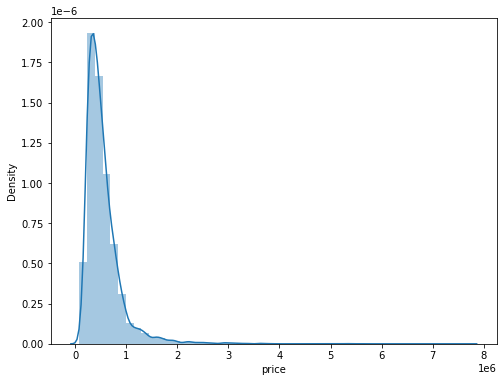

In [8]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

<AxesSubplot:xlabel='price', ylabel='Density'>

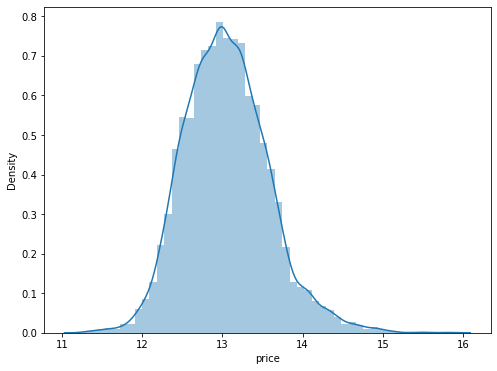

In [9]:
df_train['price'] = np.log1p(df_train['price'])
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(df_train['price'])

In [10]:
df_train["bedrooms"].drop_duplicates()

0        3
1        2
9        5
10       4
168      6
246      1
411      7
2912     9
4362     8
6885     0
9280    10
Name: bedrooms, dtype: int64

**bedrooms

bedrooms는 단순하게 침실 개수로 추정된다.